## Problema rellenar una mochila sin valores

In [2]:
import numpy as np
from scipy.sparse import csr_matrix
import torch
from time import time

In [3]:
def tensor_generator(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int, tao:float, lambda1:float):
    lista_de_tensores = []
    n_clases = len(pesos)
    inicio=time()
    tensor = tensor_initial_generator(pesos[0],valores[0],n_elementos[0],capacidad,0,tao)
    lista_de_tensores.append(tensor)
    fin = time()
    #print("tiempo creacion primr tensor", fin-inicio)
    
    inicio2=time()
    for n in range(1, n_clases-1):
        tensor = tensor_intermediate_generator(pesos[n], valores[n], n_elementos[n], capacidad, tensor.shape[1],tao)
        lista_de_tensores.append(tensor)
    fin2 = time()
    #print("tiempo creacion segundo tensor", fin2-inicio2)
    inicio3=time()
    tensor = tensor_final_generator(pesos[-1], valores[-1], n_elementos[-1], capacidad, tensor.shape[1],tao, lambda1)

    lista_de_tensores.append(tensor)
    fin3 = time()
    #print("tiempo creacion segundo tensor", fin3-inicio3)
    return lista_de_tensores



In [4]:
def tensor_initial_generator(peso:int, valor:int, n_elementos:int, capacidad:int, previous_weight_solution:int,tao)->np.array:
    """
    Funcion que genera el tensor inicial.
    """
    tamaño_1 = min((capacidad-previous_weight_solution)//peso,n_elementos)+1
    tamaño_2 = min(capacidad, (tamaño_1-1)*peso+previous_weight_solution)+1
    tensor = np.zeros((tamaño_1,tamaño_2))
    for i in range(tamaño_1):
        elemento = i*peso + previous_weight_solution
        tensor[i][elemento] = valor**i
    
    return csr_matrix(tensor)

In [5]:
'''
def tensor_intermediate_generator(peso:int, valor:int, n_elementos:int, capacidad:int, previous_weight:int, tao)->np.array:

    tamaño_1 = previous_weight
    tamaño_2 = min(capacidad, n_elementos*peso+previous_weight-1)+1
    tensor = np.zeros((tamaño_1,tamaño_2))
    for i in range(tamaño_1):
        n_elementos_restantes = min((capacidad -i)//peso,n_elementos)+1
        for  j in range(n_elementos_restantes):
            elemento = i + j*peso
            tensor[i][elemento] = np.exp(tao*valor*j)

    return csr_matrix(tensor)
'''

def tensor_intermediate_generator(peso: int, valor: int, n_elementos: int, capacidad: int, previous_weight: int, tao: float) -> csr_matrix:
    """
    Genera el tensor intermedio optimizado como una matriz dispersa (sparse) en formato CSR.
    """
    # Dimensiones del tensor
    tamaño_1 = previous_weight
    tamaño_2 = min(capacidad, n_elementos * peso + previous_weight - 1) + 1
    
    # Variables para almacenar los índices de los elementos no nulos y sus valores
    row_indices = []
    col_indices = []
    data = []

    # Vectorización para calcular las posiciones y valores no nulos
    for i in range(tamaño_1):
        n_elementos_restantes = min((capacidad - i) // peso, n_elementos) + 1
        j_values = np.arange(n_elementos_restantes)
        elemento_indices = i + j_values * peso
        valores = valor**j_values
        
        # Añadir los valores calculados a las listas
        row_indices.extend([i] * n_elementos_restantes)
        col_indices.extend(elemento_indices)
        data.extend(valores)

    # Crear la matriz dispersa directamente con los índices y valores calculados
    tensor = csr_matrix((data, (row_indices, col_indices)), shape=(tamaño_1, tamaño_2))

    return tensor


In [6]:
def tensor_final_generator(peso:int, valor:int,n_elementos: int, capacidad: int, previous_weight:int, tao:float, lambda1:float)->np.array:
    tamaño_1 = previous_weight
    tensor = np.zeros((tamaño_1))
    for i in range(tamaño_1):
        n_elementos_posibles = min((capacidad -i)//peso,n_elementos)+1
        for j in range(n_elementos_posibles):
            elemento = i +j*peso
            tensor[i] += valor**j
            #tensor[i] += np.exp(-tao*(capacidad - elemento))
            #tensor[i] += np.exp(-lambda1*(capacidad - elemento))
    return csr_matrix(tensor)

In [7]:
'''
def tensor_contraction(lista_de_tensores:list):

    n_tensores = len(lista_de_tensores)
    tensores_intermedios = []
    vector = lista_de_tensores[-1]
    tensores_intermedios.append(vector)
    for j in range(n_tensores-1,0,-1):
        if j==n_tensores-1:
            vector = lista_de_tensores[j-1] @ vector.T
        else:
            vector = lista_de_tensores[j-1] @ vector
        if max(vector) > 1e200:
            vector = vector*1e-15
        tensores_intermedios.append(vector)
    tensores_intermedios.reverse()
    return vector,tensores_intermedios
'''


import torch
from scipy.sparse import csr_matrix

def tensor_contraction(lista_de_tensores):
    n_tensores = len(lista_de_tensores)
    tensores_intermedios = []

    # Iniciar el vector como el último tensor en la lista, convertido temporalmente a PyTorch en la GPU
    vector = torch.tensor(lista_de_tensores[-1].toarray(), device='cuda')
    tensores_intermedios.append(csr_matrix(vector.cpu().numpy()))  # Guardamos en formato sparse en CPU

    # Realizar la contracción de tensores uno por uno
    for j in range(n_tensores - 1, 0, -1):
        # Convertir el tensor actual a formato denso de PyTorch temporalmente
        current_tensor = torch.tensor(lista_de_tensores[j - 1].toarray(), device='cuda')
        
        # Realizar la multiplicación y almacenar el resultado temporalmente en GPU
        if j == n_tensores - 1:
            vector = current_tensor @ vector.T
        else:
            vector = current_tensor @ vector
        
        # Normalización si es necesario para evitar overflow
        if torch.max(vector) > 1e200:
            vector = vector * 1e-15
        
        # Guardar el resultado intermedio como un tensor disperso en CPU
        tensores_intermedios.append(csr_matrix(vector.cpu().numpy()))
    
    # Convertir la lista de tensores intermedios de nuevo a formato CPU y retornar el último vector en CPU
    vector = csr_matrix(vector.cpu().numpy())
    tensores_intermedios.reverse()
    
    return vector, tensores_intermedios

In [8]:
from os import listxattr
from time import time

def solver(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int, tao:float, lambda1:float)->np.array:
    """
    Funcion que resuelve el problema de la mochila sin valores.
    """ 
    valores2 = np.exp(valores*tao)
    n_clases = len(pesos)
    solution = np.zeros(n_clases)
    inicio=time()
    lista_de_tensores = tensor_generator(pesos, valores2, n_elementos, capacidad, tao, lambda1)
    fin = time()
    #print("tiempo de la generación de los tensores", fin - inicio)
    inicio2=time()
    vector_salida, tensores_intermedios = tensor_contraction(lista_de_tensores)
    fin2 = time()
    #print("tiempo de la primra contracción de los tensores", fin2 - inicio2)

    max = np.max(tensores_intermedios[0])
    solution[0] = np.argmax(vector_salida)
    inicio3  = time()
    for n in range(1,n_clases-1):
        cuenta_peso = int(np.dot(solution[:n],pesos[:n]))
        new_initial_tensor = tensor_initial_generator(pesos[n], valores2[n], n_elementos[n], capacidad, cuenta_peso,tao)

        if n==n_clases-2:
            tensores_intermedios[n+1]=tensores_intermedios[n+1].T
            solution[n]= np.argmax(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]])
        else:
            solution[n]= np.argmax(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]])
    fin3 = time()
    #print("tiempo de la segunda contracción de los tensores", fin3 - inicio3)
    cuenta_peso = np.dot(solution[:-1],pesos[:-1])
    solution[-1] = min((capacidad-cuenta_peso)//pesos[-1],n_elementos[-1])
    resto = capacidad - np.dot(solution,pesos)

    #print("La solucion es: ", solution)
    #print("El peso total es: ", np.dot(solution,pesos))
    #print("El valor total es: ", np.dot(solution,valores))
    return np.dot(solution,pesos),np.dot(solution,valores),max

In [9]:
clases = 500
capacidad = 1000
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)


n_elementos = [6]*clases

tao = 4
lambda1 = 1

#b=solver(pesos,valores, n_elementos, capacidad, tao, lambda1)


In [10]:
def mochila_greedy(pesos, valores, capacidad, n_elementos):
    n_clases = len(pesos)
    
    # Calculamos la relación valor/peso para cada clase
    valor_peso = valores / pesos
    
    # Ordenamos los elementos por su valor/peso de mayor a menor
    indices_ordenados = np.argsort(valor_peso)[::-1]  # Orden descendente
    
    # Inicializamos variables
    peso_actual = 0
    valor_actual = 0
    solucion = np.zeros(n_clases, dtype=int)
    
    # Recorremos los objetos en orden greedy
    for i in indices_ordenados:
        # Tomamos la mayor cantidad posible de este objeto sin exceder la capacidad
        cantidad = min(n_elementos[i], (capacidad - peso_actual) // pesos[i])
        solucion[i] = cantidad
        peso_actual += cantidad * pesos[i]
        valor_actual += cantidad * valores[i]
        
        # Si llenamos la capacidad, salimos del bucle
        if peso_actual >= capacidad:
            break
    
    return solucion, valor_actual

# Ejecutamos el algoritmo

mejor_solucion, mejor_valor = mochila_greedy(pesos, valores, capacidad, n_elementos)

#print("Mejor solución encontrada (greedy):", mejor_solucion)
#print("Valor total de la mejor solución (greedy):", mejor_valor)
#print("Peso total de la mejor solución (greedy):", np.sum(mejor_solucion * pesos))

In [11]:
import matplotlib.pyplot as plt
import random
def tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,experimento):
   precision=[]
   max_values=[]
   for t in tao:

      p1,v1,max=solver(pesos,valores,n_elementos,capacidad,t,lambda1)

      p2,v2 = mochila_greedy(pesos,valores,capacidad,n_elementos)

      precision.append(v1/v2)
      max_values.append(max)
   random_color = (random.random(), random.random(), random.random())
   plt.plot(tao, precision, marker='o', color=random_color, linestyle='-')  # 'o' para puntos, 'b' para color azul, '-' para línea sólida
   plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
   # Añadir etiquetas y título
   plt.xlabel(r"$\tau$")
   plt.ylabel("precision")
   plt.title("Gráfico de línea con dos listas")
   plt.savefig(f"grafico_precision_{experimento}.png", format="png", dpi=300)

   return precision,max_values



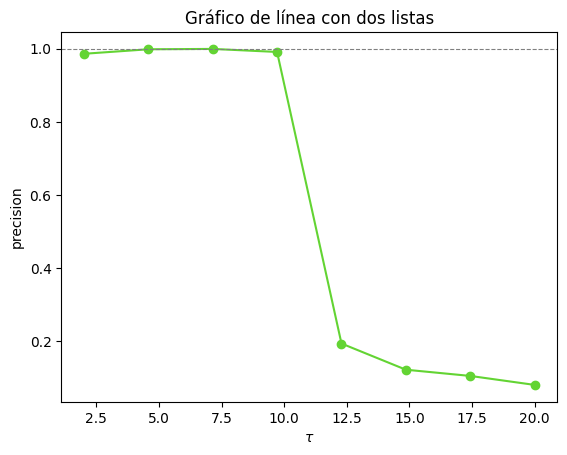

In [12]:
clases = 500
capacidad = 1000
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)

n_elementos = [9]*clases
tao = np.linspace(2,20,8)

lambda1 = 0
exp=1
precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)

In [13]:
print(precision)

[0.9862508401095953, 0.9986061665958103, 0.9995681253953067, 0.9912939505792303, 0.19338776156951745, 0.12175477795574265, 0.1047296841441658, 0.08014177948664115]


In [14]:
import matplotlib.pyplot as plt
from time import time
tao=0.5
num_clases=np.arange(10,11)
tiempo=[]
precision=[]
for j in num_clases:
    pesos = np.random.randint(1,10,j)
    n_elementos = [3]*j
    capacidad = j*10
    inicio=time()
    b=solver(pesos, n_elementos, capacidad, tao)
    resultado=np.dot(b,pesos)
    fin=time()
    tiempo.append(fin-inicio)
    precision.append(resultado/capacidad)



plt.plot(num_clases, precision, marker='o', color='b', linestyle='-')  # 'o' para puntos, 'b' para color azul, '-' para línea sólida

# Añadir etiquetas y título
plt.xlabel("num_clases")
plt.ylabel("tiempo")
plt.title("Gráfico de línea con dos listas")

# Mostrar el gráfico
plt.show()

TypeError: solver() missing 2 required positional arguments: 'tao' and 'lambda1'